In [16]:
import xarray as xr
import dask.array as da
import numpy as np
from blimpy.io import sigproc
import pylab as plt
import os
from astropy import units as u
from astropy.coordinates import SkyCoord
import hyperseti
import h5py

filpath = '/home/dancpr/blimpy/tests/test_data/Voyager1.single_coarse.fine_res.fil'
h5path = '/home/dancpr/blimpy/tests/test_data/Voyager1.single_coarse.fine_res.h5'

In [62]:
type(dask_data)

dask.array.core.Array

In [79]:
import numpy as np
import xarray as xr
N, M = 10, 2**16
freq0, freq_step = 1000.0, 0.1
data = np.zeros(shape=(N, M))
time_arr = np.arange(0, N)
freq_arr = freq0 + freq_step * np.arange(0, M)
data_array = xr.DataArray(data, dims=('timestep', 'frequency'), coords={'timestep': time_arr, 'frequency': freq_arr} )


<xarray.DataArray (timestep: 10, frequency: 65536)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * timestep   (timestep) int64 0 1 2 3 4 5 6 7 8 9
  * frequency  (frequency) float64 1e+03 1e+03 1e+03 ... 7.553e+03 7.554e+03

In [81]:
data_array.sel(frequency=slice(1000, 1010))

<xarray.DataArray (timestep: 10, frequency: 101)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * timestep   (timestep) int64 0 1 2 3 4 5 6 7 8 9
  * frequency  (frequency) float64 1e+03 1e+03 1e+03 ... 1.01e+03 1.01e+03

In [58]:
N_COARSE = 4
hdr    = sigproc.read_header(filpath)
hdrlen = sigproc.len_header(filpath)
n_int  = sigproc.calc_n_ints_in_file(filpath)
shape  = (n_int,  hdr['nbeams'], hdr['nchans'])
#data = np.memmap(filename=filpath, dtype='float32', offset=hdrlen, shape=shape)
data = h5py.File(h5path)['data']
dask_data = da.from_array(data, chunks=(16, 1, hdr['nchans'] // N_COARSE), name=os.path.basename(filpath))
xr_data   = xr.DataArray(dask_data, dims=('time', 'pol', 'frequency'))                        

xr_data.attrs['t0'] = hdr['tstart'] * u.s
xr_data.attrs['dt'] = hdr['tsamp'] * u.s
xr_data.attrs['f0'] = hdr['fch1']  * u.MHz
xr_data.attrs['df'] = hdr['foff'] * u.MHz
xr_data.attrs['skycoord'] = SkyCoord(hdr['src_raj'], hdr['src_dej'])
xr_data.attrs['source']   = hdr['source_name']
xr_data = xr_data.squeeze()
xr_data

<xarray.DataArray 'Voyager1.single_coarse.fine_res.fil' (time: 16, frequency: 1048576)>
dask.array<getitem, shape=(16, 1048576), dtype=float32, chunksize=(16, 262144), chunktype=numpy.ndarray>
Dimensions without coordinates: time, frequency
Attributes:
    t0:        57650.78209490741 s
    dt:        18.253611008 s
    f0:        8421.386717353016 MHz
    df:        -2.7939677238464355e-06 MHz
    skycoord:  <SkyCoord (ICRS): (ra, dec) in deg\n    (257.5166, 12.183)>
    source:    Voyager1

In [18]:
from hyperseti import run_pipeline

In [19]:
metadata = {'fch1': xr_data.attrs['f0'],
            'dt': xr_data.attrs['dt'],
            'df': xr_data.attrs['df']}

In [20]:
import dask
from dask.diagnostics import ProgressBar

In [30]:
def run_pipeline_wrapper(data, *args, **kwargs):
    #d = data.mean()
    dedopp, md, peaks = run_pipeline(*args, **kwargs)
    return peaks

dograph = dask.delayed(run_pipeline_wrapper)(xr_data, metadata, max_dd=1.0, min_dd=None, threshold=20, 
                                    n_boxcar=5, merge_boxcar_trials=True)

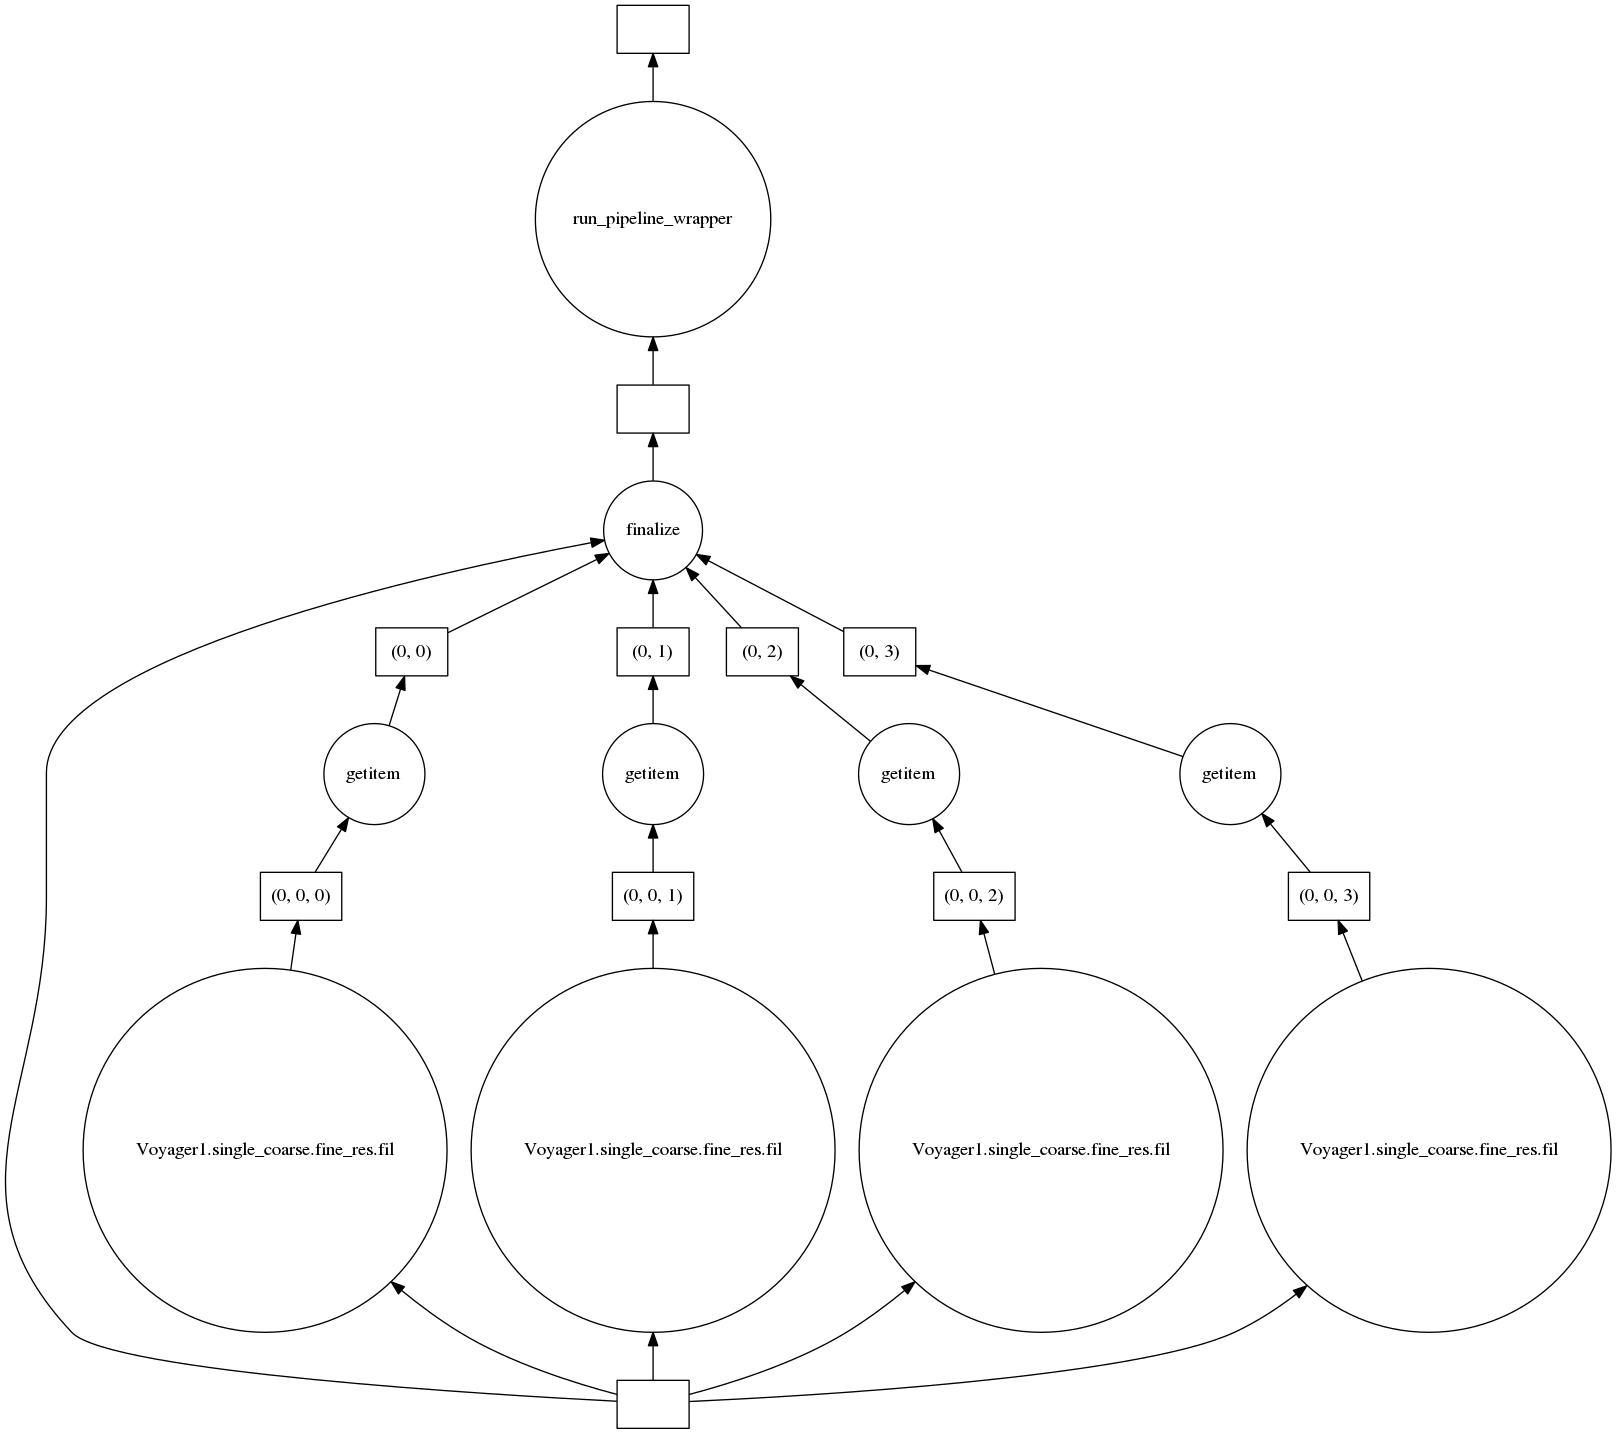

In [22]:
dograph.visualize()

In [23]:
with ProgressBar():
    out = dograph.compute(n_workers=1)

[########################################] | 100% Completed |  1.6s


In [32]:
xr_data.map_blocks(run_pipeline_wrapper, metadata, max_dd=1.0, min_dd=None, threshold=20, 
                                    n_boxcar=5, merge_boxcar_trials=True)

TypeError: map_blocks() got an unexpected keyword argument 'max_dd'

In [26]:
xr_data.mean().compute()

<xarray.DataArray 'Voyager1.single_coarse.fine_res.fil' ()>
array(1.0394075e+10, dtype=float32)

In [26]:
import logbook
hyperseti.logger_group.level = logbook.INFO
#hyperseti.peak.logger.level  = logbook.DEBUG

In [ ]:
run_pipeline(D, metadata, max_dd=1.0, min_dd=None, threshold=20, n_boxcar=5, merge_boxcar_trials=True)

[2021-04-14 10:55:38.887127] INFO: hyperseti.hyperseti: --- Boxcar size: 1 ---
[2021-04-14 10:55:44.660764] INFO: hyperseti.hyperseti: Dedopp setup time: 5772.32ms
[2021-04-14 10:55:44.662445] INFO: hyperseti.hyperseti: Dedopp kernel time: 0.25ms


In [238]:
from astropy.units import Unit, Quantity

class DimensionScale(object):
    """ Dimension Scale """
    def __init__(self, name, val_start, val_step, n_step, units=None):
        self.name = name
        self.val_start = val_start
        self.val_step  = val_step
        self.n_step    = n_step
        if isinstance(units, str):
            units = Unit(units)
        self.units     = units
        
    def __repr__(self):
        return f"<DimensionScale '{self.name}': start {self.val_start} {self.units} step {self.val_step} {self.units} nstep {self.n_step} >"
    
    def __array__(self):
        return self.generate_array()

    def __getitem__(self, i):
        if isinstance(i, slice):
            skip  = 1 if i.step is None else i.step
            start = 0 if i.start is None else i.start
            stop  = self.n_step if i.stop is None else i.stop
            new_val_start = self.val_start + start * self.val_step
            new_n_step = (stop - start) // skip
            new_step_val = self.val_step * skip
            #return self.val_start + self.val_step * np.arange(start, stop, step)
            return DimensionScale(self.name, new_val_start, new_step_val, new_n_step, units=self.units)
        else:
            return i * self.val_step + self.val_start
        
    def generate_array(self, start_idx=None, stop_idx=None):
        """ Generate an numpy array from this DimensionScale object
        
        This is called by __array__() with no args for np.asarray support.
        """
        start_idx = 0 if start_idx is None else start_idx
        stop_idx = self.n_step if stop_idx is None else stop_idx
        return Quantity(np.arange(start_idx, stop_idx) * self.val_step + self.val_start, unit=self.units)
    
    def index(self, val, val2=None):
        #x = x0 + i * dx
        # i = (x - x0) / dx
        if isinstance(val, np.ndarray):
            i = ( (val - self.val_start) / self.val_step).astype('int32')
            if np.min(i) < 0:
                raise ValueError("one or more values fall outside DimensionScale range")
            return i
        else:
            i = round( (val - self.val_start) / self.val_step)
            if i < 0:
                    raise ValueError("value falls outside DimensionScale range")
            if val2 is None:
                return i
            else:
                j = round( (val2 - self.val_start) / self.val_step)
                if j < 0:
                    raise ValueError("value2 falls outside DimensionScale range")
                return i, j
    
ds = DimensionScale('frequency', 1000, 0.1, n_step=100, units=u.GHz)
print(ds)
ds = DimensionScale('frequency', 1000, 0.1, n_step=100, units='GHz')
print(ds)

#ds_slice = ds.slice(5, 9)
#print(ds_slice)

# Check conversion to array
print(np.asarray(ds))
print(ds_slice.generate_array())
ds_arr = ds.generate_array(0, 10)
print(ds_arr)

# Check fancy indexing
print("--INDEXING---")
print(ds[10:20])
print(ds[10:20:2])
print(np.asarray(ds[10:20:2]))
print(ds_arr[5:9])

# Check indexing
print(ds.index(1008))
print(ds.index(1008, 1010))
print(ds.index(np.arange(1000, 1010)))

<DimensionScale 'frequency': start 1000 GHz step 0.1 GHz nstep 100 >
<DimensionScale 'frequency': start 1000 GHz step 0.1 GHz nstep 100 >
[1000.  1000.1 1000.2 1000.3 1000.4 1000.5 1000.6 1000.7 1000.8 1000.9
 1001.  1001.1 1001.2 1001.3 1001.4 1001.5 1001.6 1001.7 1001.8 1001.9
 1002.  1002.1 1002.2 1002.3 1002.4 1002.5 1002.6 1002.7 1002.8 1002.9
 1003.  1003.1 1003.2 1003.3 1003.4 1003.5 1003.6 1003.7 1003.8 1003.9
 1004.  1004.1 1004.2 1004.3 1004.4 1004.5 1004.6 1004.7 1004.8 1004.9
 1005.  1005.1 1005.2 1005.3 1005.4 1005.5 1005.6 1005.7 1005.8 1005.9
 1006.  1006.1 1006.2 1006.3 1006.4 1006.5 1006.6 1006.7 1006.8 1006.9
 1007.  1007.1 1007.2 1007.3 1007.4 1007.5 1007.6 1007.7 1007.8 1007.9
 1008.  1008.1 1008.2 1008.3 1008.4 1008.5 1008.6 1008.7 1008.8 1008.9
 1009.  1009.1 1009.2 1009.3 1009.4 1009.5 1009.6 1009.7 1009.8 1009.9]
[1000.5 1000.6 1000.7 1000.8] GHz
[1000.  1000.1 1000.2 1000.3 1000.4 1000.5 1000.6 1000.7 1000.8 1000.9] GHz
--INDEXING---
<DimensionScale 'frequency'

In [221]:
a = np.array([1,2,3, -4, 5])
np.min(a)

-4

In [175]:
import numpy as np
HANDLED_FUNCTIONS = {}

class DimensionScale:
    def __init__(self, start, step, nstep):
        self._start = start
        self._step = step
        self._nstep = nstep
        self.shape = (nstep,)
        self.ndim  = 1
        self.dtype = np.dtype('float64')

    def __repr__(self):
        return f"{self.__class__.__name__}(start={self._start}, step={self._step})"

    def __array__(self):
        return self._start + self._step * np.arange(0, self._nstep)

    def __array_function__(self, func, types, args, kwargs):
        if func not in HANDLED_FUNCTIONS:
            return NotImplemented
        # Note: this allows subclasses that don't override
        # __array_function__ to handle DimensionScale objects
        if not all(issubclass(t, DimensionScale) for t in types):
            return NotImplemented
        return HANDLED_FUNCTIONS[func](*args, **kwargs)
    
    def __getitem__(self, i):
        if isinstance(i, slice):
            step  = 1 if i.step is None else i.step
            start = 0 if i.start is None else i.start
            stop  = self._nstep if i.stop is None else i.stop
            return self._start + self._step * np.arange(start, stop, step)
        else:
            return i * self._i

def implements(numpy_function):
    """Register an __array_function__ implementation for MyArray objects."""
    def decorator(func):
        HANDLED_FUNCTIONS[numpy_function] = func
        return func
    return decorator
        
arr = DimensionScale(5, 2, 100)
arr
arr[:]

N, M = 10, 2**20
data = np.eye(N, M)
time_coords = np.arange(0, N)
#freq_coords = freq0 + freq_step * np.arange(0, M)
freq_coords = DimensionScale(freq0, freq_step, M)
data_array = xr.DataArray(data, dims=('timestep', 'frequency'), coords={'timestep': time_coords, 'frequency': freq_coords} )

In [180]:
data_array

<xarray.DataArray (timestep: 10, frequency: 1048576)>
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * timestep   (timestep) int64 0 1 2 3 4 5 6 7 8 9
  * frequency  (frequency) float64 1e+03 1e+03 1e+03 ... 1.059e+05 1.059e+05

In [145]:
s = slice(None)

In [146]:
d = np.array([1,2,3])

In [148]:
d[s]

array([1, 2, 3])

In [248]:
a = 1000.0 * u.MHz
b = 1.0 * u.GHz
c = b+a
c.value

2.0

In [250]:
c.to('MHz')

<Quantity 2000. MHz>